# The Full Pipeline

**Inputs**: 
- scope 
- background image file path for 2159 scope
- experiment data
- config file
- timepoints (tp)

**Outputs**:
- droplets DataFrame (csv) 
- condensed DataFrame (csv)
- trimmed DataFrame (csv)

**Imports**:
- import python packages
- import kchip package depending on scope

Step 0: Average background images for 2159 scope

Step 1: Create droplets DataFrame
Compute and store:
- the RGB information of each droplet
- the cluster and cluster label of each droplet
- the location of each droplet
- the well ID of each droplet

Step 2: Create condensed DataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells
- condense outputs to final dataframe

Step 3:
- filter droplets out based on barcode distances from cluster centroid
- filter dropelts out based on droplet area size
- check well locations
- check label counts

Step 4: 
- format output data for heatmap plotting
- get replicate counts for important combos
- get median, median tX-t0, and standard deviation values
- plot heatmaps


# Inputs (RUN FIRST)

In [1]:
## Data analysis inputs ##
# date of experiment (KEEP the underscore after the date)
exp_date = "20201016_" 

# Chip number
chip_id = 'Pa2_P2'
# config file - path to your config file
config_file = 'Pa2_P2_config.yml' 
# generates new folder for saving outputs
newfolder = './Pa2_P2_output/' 
# number of timepoints to analyze
tp = 2

# Imports and config
- rescaling and bkg averaging

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


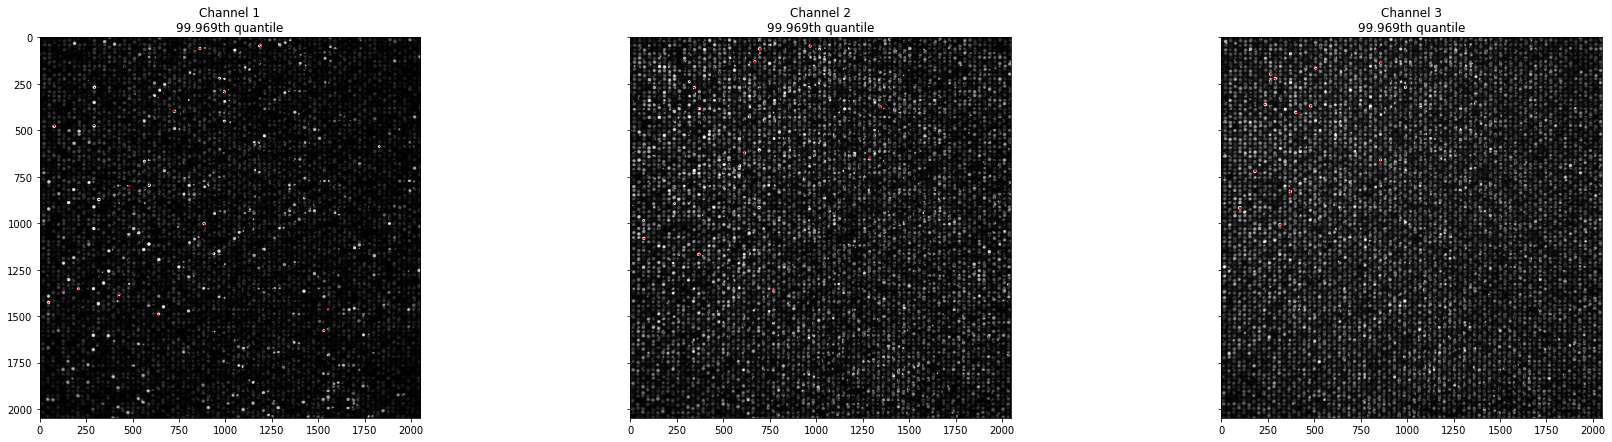

Rescale vector: [1.2, 1.0, 1.6, 1]
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(9, 2048, 2048, 4)
(2048, 2048, 4)
img16trans shape is: (4, 2048, 2048)
(2048, 2048, 4)


In [2]:
# Make output data folder
import os
os.makedirs(newfolder, exist_ok=True)
# imports
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import sys
sys.path.insert(1, '../')
# kchip imports
import kchip_py3_v2.io as kchip_io
import kchip_py3_v2.analyze as kchip_analyze
import kchip_py3_v2.bchip as bchip
import kchip_py3_v2.rescale as kchip_r
kchip_r.rescale_config(config_file,config_file)

# Read in config file
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile)

import kchip_py3_v2.background as kchip_bkg
kchip_bkg.avg_bkg(config)

# Create Droplets df
- Initialize from images
- Identify droplets in the same well from fit to masks
- Cluster
- Map apriori labels to clusters

In [3]:
from importlib import reload
reload(kchip_analyze)
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile)
# Initialize droplets DataFrame from images
droplets, rotation_theta = kchip_analyze.initialize_droplets(config)
# print 'Rotation (degrees): ', rotation_theta*180/np.pi
droplets.to_csv(newfolder+exp_date+'droplets_found.csv')
## Identify droplets in the same well from fit to masks
# droplets = kchip_analyze.fit_droplets_to_mask(config,droplets,rotation_theta)
# droplets.to_csv('droplets_assigned.csv')

Creating droplets from: 2,6
Found 5255 Droplets
Creating droplets from: 2,5
Found 5729 Droplets
Creating droplets from: 2,4
Found 5673 Droplets
Creating droplets from: 2,3
Found 5589 Droplets
Creating droplets from: 2,2
Found 5388 Droplets
Creating droplets from: 2,1
Found 4370 Droplets
Creating droplets from: 1,6
Found 3022 Droplets
Creating droplets from: 1,5
Found 4854 Droplets
Creating droplets from: 1,3
Found 4549 Droplets
Creating droplets from: 1,4
Found 4639 Droplets
Creating droplets from: 1,2
Found 4490 Droplets
Creating droplets from: 1,1
Found 3556 Droplets
Creating droplets from: 5,3
Found 5825 Droplets
Creating droplets from: 5,1
Found 5067 Droplets
Creating droplets from: 4,6
Found 5602 Droplets
Creating droplets from: 4,5
Found 5646 Droplets
Creating droplets from: 4,4
Found 5450 Droplets
Creating droplets from: 4,3
Found 5419 Droplets
Creating droplets from: 4,2
Found 5190 Droplets
Creating droplets from: 4,1
Found 4690 Droplets
Creating droplets from: 3,6
Found 5316 D

In [4]:
# Remove overlap and identify drops in same well for k=2
print(droplets.shape)
# removes 5% image overlap AND pairs droplets in the same well
droplets = bchip.remove_overlap(config,droplets,show=1)
# creates a HASH unique to each well
droplets = bchip.hashdrops(droplets)
# Saves droplets assigned to wells and prints droplet count
droplets.to_csv(newfolder+exp_date+'droplets_wells_assigned.csv')
print ('all droplets (overlap removed)',droplets.shape)

(277082, 9)
Removed: 21524 wells from dataFrame due to overlap in images.
all droplets (overlap removed) (214612, 11)


In [5]:
# Removes wells with only one droplet and saves wells with combos
# prints combo droplet count and df head
droplets = droplets[droplets.groupby('Hash').Hash.transform(len) > 1]
droplets.to_csv(newfolder+exp_date+'droplets_wells_assigned_combos.csv')
print ('combos only',droplets.shape)
droplets.head()

combos only (187256, 11)


IndexX  IndexY  ImageX  ImageY     Dye 0     Dye 1     Dye 2          RX  \
0       2       6    1331    1831  6088.608   7147.88  7286.464 -175.047481   
2       2       6     532     748   214.368  22544.80  7011.776  -80.444302   
7       2       6    1744     655   132.240   5771.08  8686.976  902.198228   
8       2       6    1178     628  2427.120   8159.88  6689.280  489.001207   
9       2       6    1772     627  1970.592   3500.80  8721.408  941.671383   

            RY  Well_ID                 Hash  
0  2256.874028   1862.0  3789698711986628713  
2   914.361370    922.0  3789698710835560301  
7  1629.907776    178.0  3789698711776919893  
8  1242.153702   1845.0  3789698711929541312  
9  1626.766119   2562.0  3789698708626627397

In [6]:
# Corrects dye bleed through
droplets['Dye 1 corr']=droplets['Dye 1'].values-(0.02*droplets['Dye 2'].values)
droplets['Dye 2 corr']=droplets['Dye 2'].values-(0.14*droplets['Dye 1'].values)
# reset column names for clustering code
droplets[['R','G','B']]=\
    droplets[['Dye 0', 'Dye 1 corr', 'Dye 2 corr']] 
droplets.to_csv(newfolder+exp_date+'droplets_dye_correction.csv')
droplets.head()

IndexX  IndexY  ImageX  ImageY     Dye 0     Dye 1     Dye 2          RX  \
0       2       6    1331    1831  6088.608   7147.88  7286.464 -175.047481   
2       2       6     532     748   214.368  22544.80  7011.776  -80.444302   
7       2       6    1744     655   132.240   5771.08  8686.976  902.198228   
8       2       6    1178     628  2427.120   8159.88  6689.280  489.001207   
9       2       6    1772     627  1970.592   3500.80  8721.408  941.671383   

            RY  Well_ID                 Hash   Dye 1 corr  Dye 2 corr  \
0  2256.874028   1862.0  3789698711986628713   7002.15072   6285.7608   
2   914.361370    922.0  3789698710835560301  22404.56448   3855.5040   
7  1629.907776    178.0  3789698711776919893   5597.34048   7879.0248   
8  1242.153702   1845.0  3789698711929541312   8026.09440   5546.8968   
9  1626.766119   2562.0  3789698708626627397   3326.37184   8231.2960   

          R            G          B  
0  6088.608   7002.15072  6285.7608  
2   214.368  22404.56448  3855.5040  
7   132.240   5597.34048  7879.0248  
8  2427.120   8026.09440  5546.8968  
9  1970.592   3326.37184  8231.2960

# Interactive Clustering

In [7]:
droplets = pd.read_csv(newfolder+exp_date+'droplets_dye_correction.csv',index_col=0)
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile)

In [10]:
# Troubleshooting the barcode pandas dataframe index
barcodes = pd.read_excel(config['barcodes']['path'],sheet_name='Barcodes',index_col=0)
labels = pd.read_excel(config['barcodes']['path'],sheet_name='Labels',index_col=0)
labels

0       1      2        3       4      5      6       7      8      9   \
0  SUL_1  TIGE_1  AMP_1  COLIS_1  LEVO_1  NOV_1  TET_1  VANC_1  CEP_1  IMP_1   
1  SUL_2  TIGE_2  AMP_2  COLIS_2  LEVO_2  NOV_2  TET_2  VANC_2  CEP_2  IMP_2   
2  SUL_3  TIGE_3  AMP_3  COLIS_3  LEVO_3  NOV_3  TET_3  VANC_3  CEP_3  IMP_3   
3  SUL_4  TIGE_4  AMP_4  COLIS_4  LEVO_4  NOV_4  TET_4  VANC_4  CEP_4  IMP_4   
4  SUL_5  TIGE_5  AMP_5  COLIS_5  LEVO_5  NOV_5  TET_5  VANC_5  CEP_5  IMP_5   
5  SUL_6  TIGE_6  AMP_6  COLIS_6  LEVO_6  NOV_6  TET_6  VANC_6  CEP_6  IMP_6   
6  SUL_7  TIGE_7  AMP_7  COLIS_7  LEVO_7  NOV_7  TET_7  VANC_7  CEP_7  IMP_7   
7  SUL_8  TIGE_8  AMP_8  COLIS_8  LEVO_8  NOV_8  TET_8  VANC_8  CEP_8  IMP_8   

   ...  12  13  14  15      16  17  18  19  20       21  
0  ... NaN NaN NaN NaN  BUGS_1 NaN NaN NaN NaN  CAMHB_1  
1  ... NaN NaN NaN NaN  BUGS_2 NaN NaN NaN NaN  CAMHB_2  
2  ... NaN NaN NaN NaN  BUGS_3 NaN NaN NaN NaN  CAMHB_3  
3  ... NaN NaN NaN NaN     NaN NaN NaN NaN NaN      NaN  
4  ... NaN NaN NaN NaN     NaN NaN NaN NaN NaN      NaN  
5  ... NaN NaN NaN NaN     NaN NaN NaN NaN NaN      NaN  
6  ... NaN NaN NaN NaN     NaN NaN NaN NaN NaN      NaN  
7  ... NaN NaN NaN NaN     NaN NaN NaN NaN NaN      NaN  

[8 rows x 22 columns]

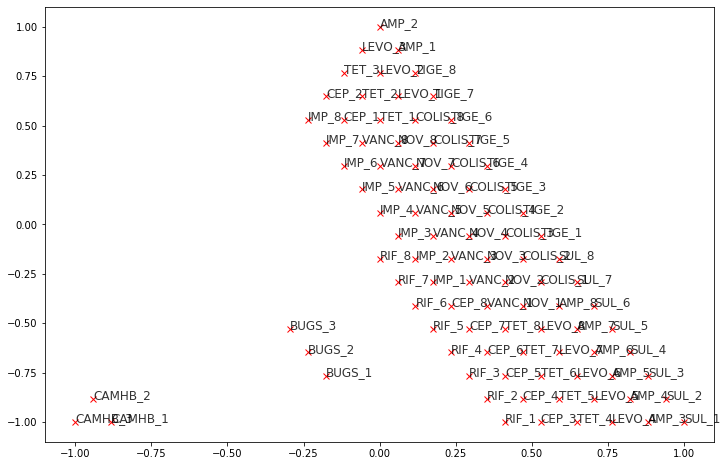

In [11]:
kchip_analyze.cluster_ref(config)
plt.gcf().set_size_inches(12,8)
plt.savefig(newfolder+exp_date+'cluster_reference.png',dpi=300)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Total droplets identified:  187256
(93, 2)


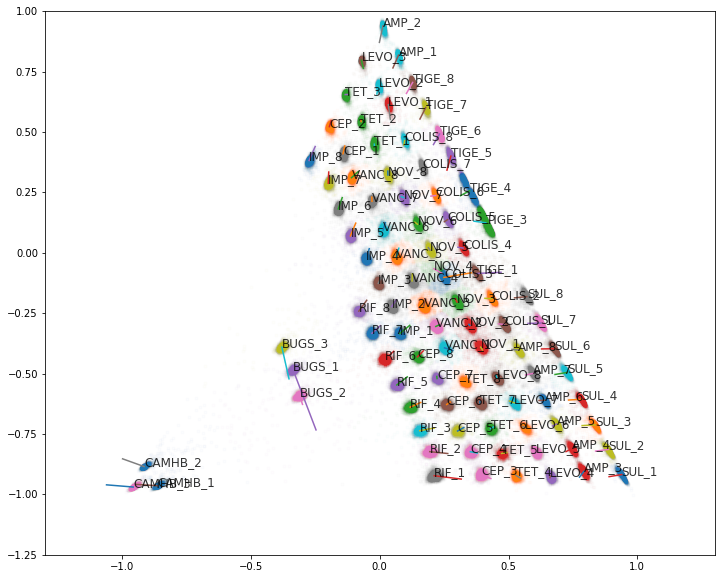

In [12]:
# ASSIGNS LABELS TO CLUSTERS
# Key error will likely appear
# This is because more clusters were found than labels provided
# Fix by increasing the number of min sample from the config file
# OR by using Interactive clustering code

config['barcodes']['cluster']['eps'] = 0.02 
config['barcodes']['cluster']['min_samples'] = 4

fig, ax = plt.subplots()

# Cluster droplets and map apriori labels to clusters
droplets, centroids, on_plane = kchip_analyze.identify_clusters(config,droplets,show=1,ax=ax)
droplets, centroids = kchip_analyze.map_labels_to_clusters(config, droplets, show=1,ax=ax)
# droplets.to_csv('droplets_clustered_scaled.csv')

print ('Total droplets identified: ', droplets.shape[0])
print(centroids.shape)

plt.gca().set_xlim(-1.3,1.3)
plt.gca().set_ylim(-1.25, 1)
plt.gcf().set_size_inches(12,10)
# plt.savefig(newfolder+exp_date+'clusters_scaled_corr.png',bbox_inches='tight')

In [13]:
x = labels.fillna('_').values.reshape(labels.size,1)
all_labels = x[x != '_'].tolist()
print('Total clusters you should have:',len(all_labels))

Total clusters you should have: 94


In [14]:
# # Import the interactive tools
import kchip_py3.tools.interact as interact

# # Create InteractiveCluster object
centroids = droplets.groupby('Cluster')[['PlaneX','PlaneY']].median().values
rc = interact.InteractiveCluster(droplets[['PlaneX','PlaneY']].values[-5000:,:],centroids)

# Show the plot
interact.bqplt.show()

# Change the point opacities for better viewing, as desired
rc.sca_points.default_opacities = [.2]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


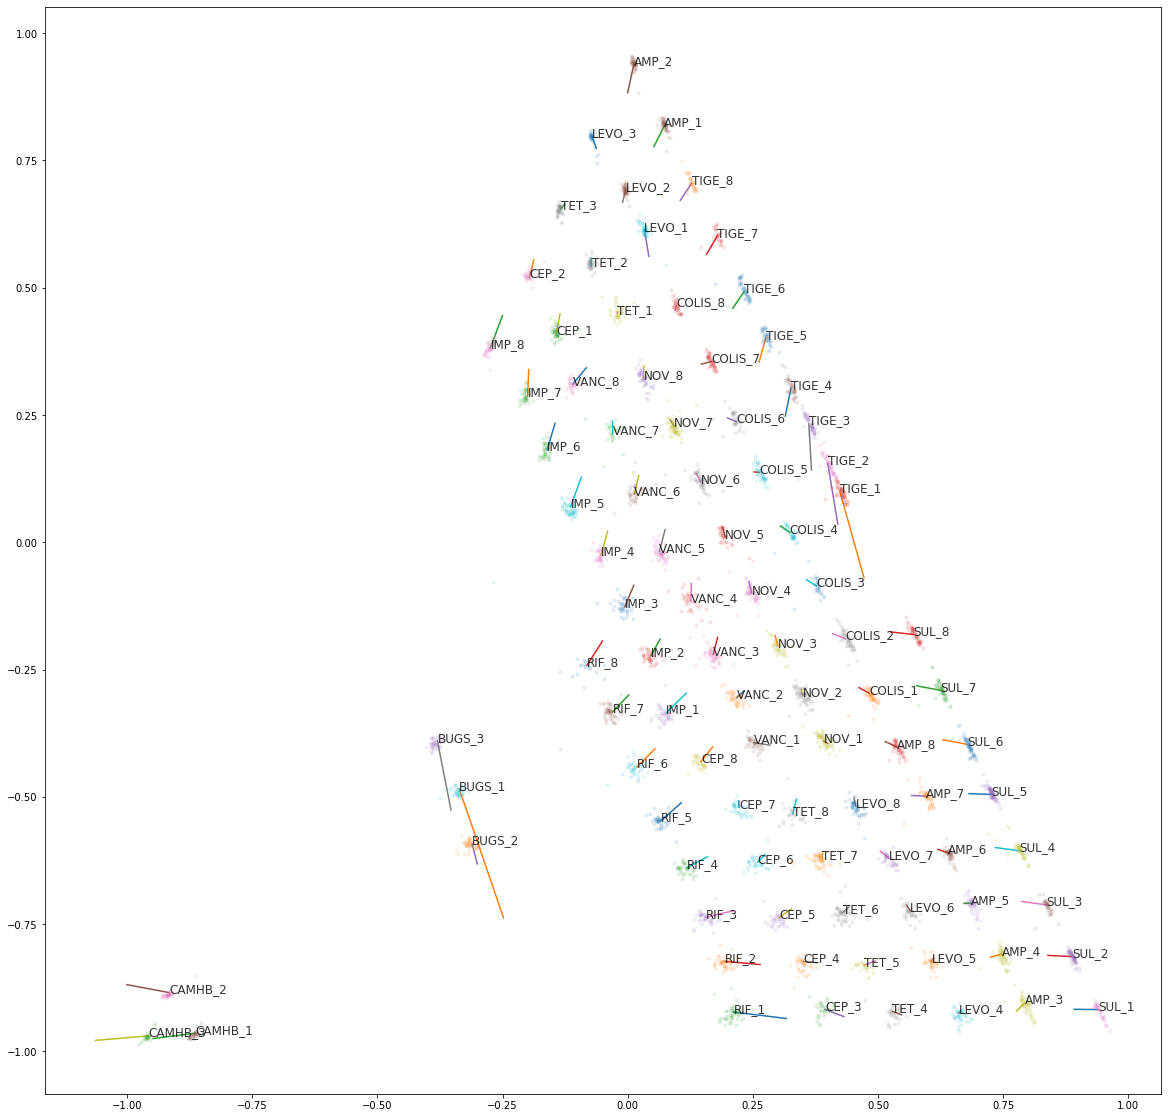

In [15]:
# Update the droplets dataframe with new cluster assignments
droplets['Cluster']=rc.cluster(droplets[['PlaneX','PlaneY']].values)

# Map labels to clusters
fig, ax = plt.subplots(figsize=(20,20))

# Use the updated cluster centroids from the interactive plot
droplets = kchip_analyze.map_labels_to_clusters(config,droplets,show=1,ax=ax)[0]

# Replot the points to view the clusters

d = droplets.loc[:5e3] # only choose the first 5000 points so we don't overload matplotlib
for item in droplets['Cluster'].unique():
    xy = d.query('Cluster=='+str(item))[['PlaneX','PlaneY']].values
    ax.plot(xy[:,0],xy[:,1],'.',alpha=0.1)

# Save the triangle
plt.savefig(newfolder+exp_date+'_clusters_scaled_corr.png',bbox_inches='tight')

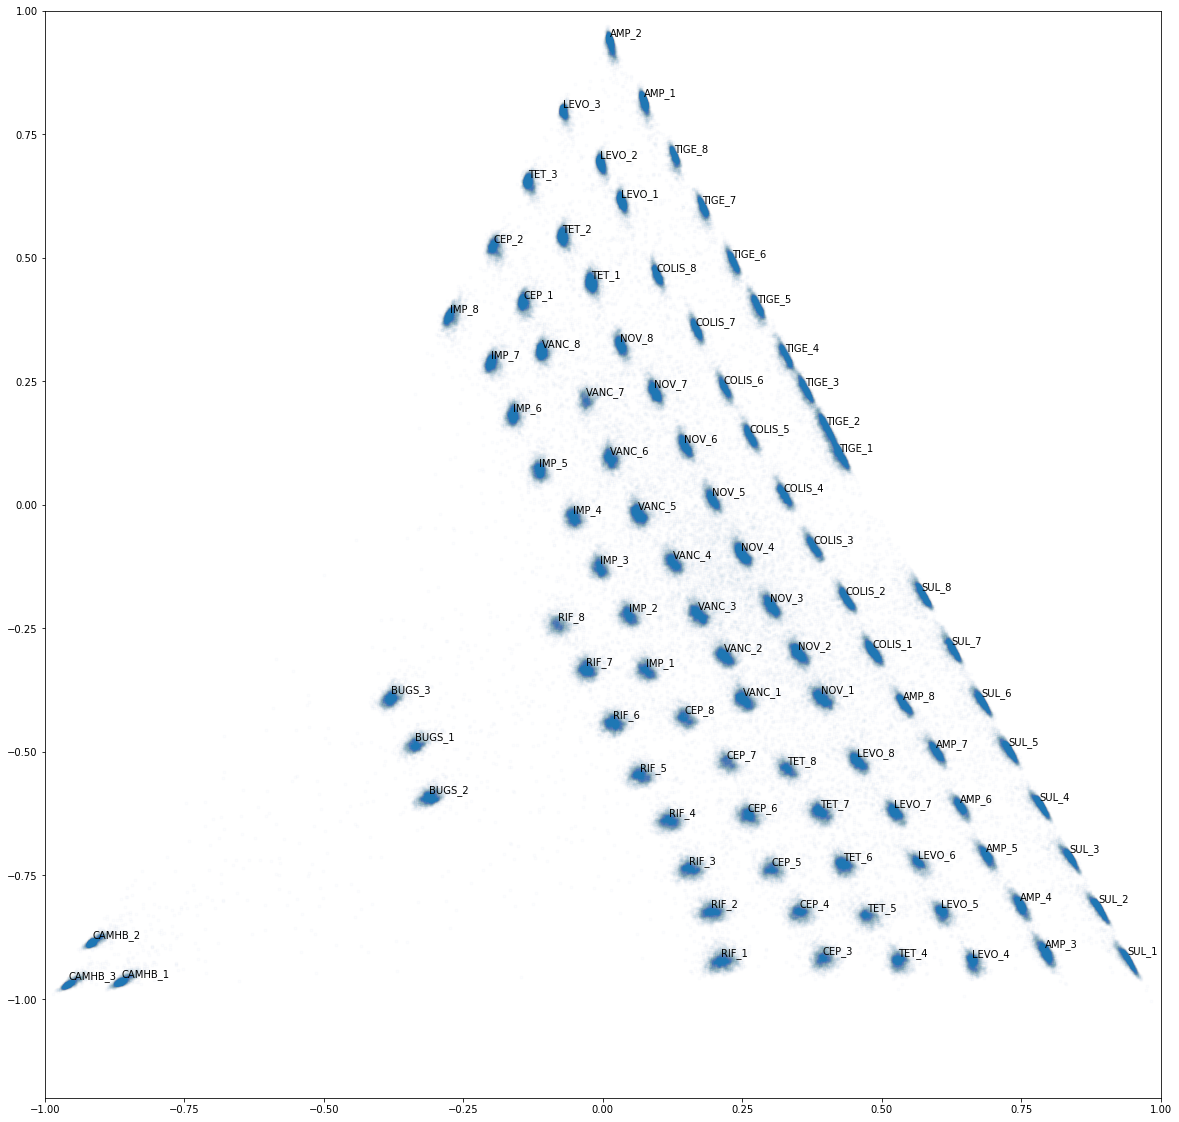

In [16]:
droplets['CentroidX'] = droplets.groupby('Label')['PlaneX'].transform('mean')
droplets['CentroidY'] = droplets.groupby('Label')['PlaneY'].transform('mean')
droplets['distance'] = np.sqrt((droplets.PlaneX-droplets.CentroidX)**2+\
                              (droplets.PlaneY-droplets.CentroidY)**2)
fig, ax = plt.subplots(figsize=(20,20))
plt.xlim([-1,1])
plt.ylim([-1.2,1])
ax.plot(droplets.PlaneX,droplets.PlaneY,'.',alpha=0.01)
d = droplets.groupby('Label').median()[['PlaneX','PlaneY']]
for label in d.index.values:
    ax.text(d.loc[label,'PlaneX'],d.loc[label,'PlaneY']+0.01,label)
plt.savefig(newfolder+exp_date+'_experimental.png',dpi=300)

In [17]:
droplets.to_csv(newfolder+exp_date+'droplets_clustered_corrected_all.csv')

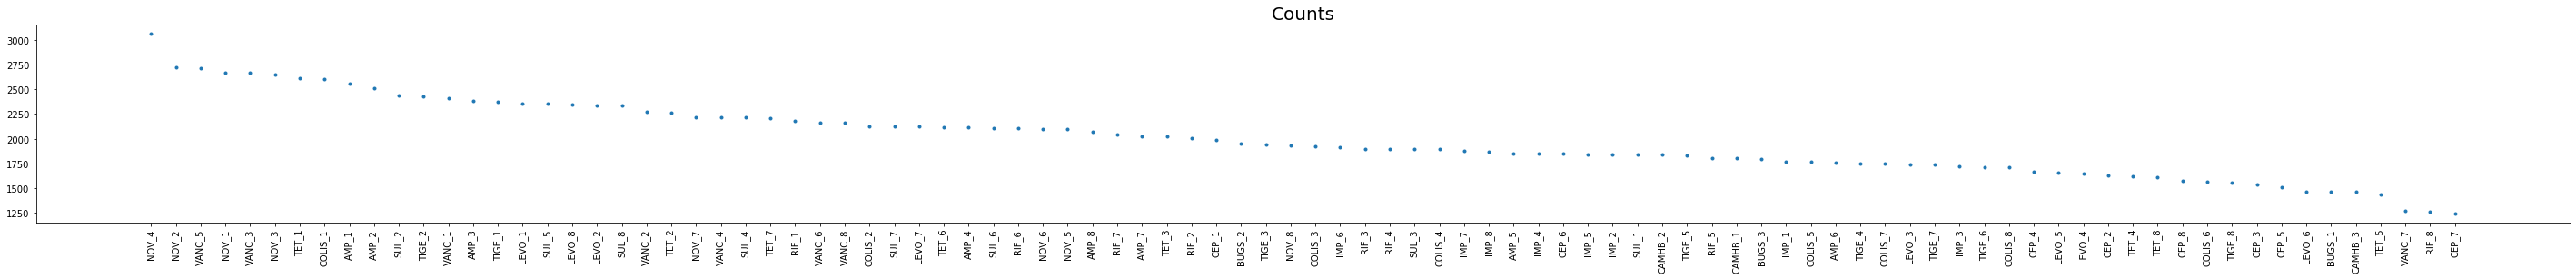

In [18]:
fig, axes = plt.subplots(1,1,figsize=(50,4))
plt.plot(droplets.Label.value_counts(),'.')
axes.set_xticks(range(len(droplets.Label.unique())))
axes.set_xticklabels(droplets.Label.value_counts().index,size=10,rotation=90)
axes.set_title('Counts',size=20)
plt.savefig(newfolder+exp_date+'_cluster_count.png',dpi=300,bbox_inches='tight')

# Creates Condensed df
- Create pre-merge wells dataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells

In [4]:
# If reading in csv file:
droplets = pd.read_csv(newfolder+exp_date+'droplets_clustered_corrected_all.csv',index_col=0)

# Re-read in config file
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile)

# Identify premerge wells
pre_wells = droplets.groupby(['IndexX','IndexY','Well_ID'],as_index=False)[['ImageX','ImageY']].mean()
print(pre_wells)

# List of timepoints
timepoints = ['t'+str(i) for i in range(tp)]
#timepoints = ['t0']
print(timepoints)

# Analyze data for each timepoint
pre_post_all = []
for timepoint in timepoints:
    print ('Now analyzing timepoint: ', timepoint)
    # Identify postmerge wells and map to pre-merge wells
    pre_post_all.append(kchip_analyze.map_pre_to_post(config,timepoint,pre_wells))

# Condense output
condensed = kchip_analyze.stack_timepoints(droplets,pre_post_all,timepoints)
# Pre_post output
pre_post = pd.DataFrame(pre_post_all[0]) 

       IndexX  IndexY  Well_ID  ImageX  ImageY
0           1       1      1.0  1093.5  1914.5
1           1       1      2.0  1094.5   851.5
2           1       1      4.0  1281.5  1520.0
3           1       1      5.0  1470.0   756.5
4           1       1      7.0  1336.0  1842.5
...       ...     ...      ...     ...     ...
93623       9       6   2746.0  1413.5   325.0
93624       9       6   2747.0  1550.0   328.5
93625       9       6   2748.0   170.5   381.0
93626       9       6   2749.0   883.0  1615.0
93627       9       6   2750.0  1056.5   830.0

[93628 rows x 5 columns]
['t0', 't1']
Now analyzing timepoint:  t0
Now analyzing: 1,2
Now analyzing: 1,1
Now analyzing: 3,5
Now analyzing: 3,4
Now analyzing: 3,3
Now analyzing: 3,2
Now analyzing: 3,1
Now analyzing: 2,6
Now analyzing: 2,4
Now analyzing: 2,5
Now analyzing: 2,3
Now analyzing: 2,2
Now analyzing: 2,1
Now analyzing: 1,6
Now analyzing: 1,5
Now analyzing: 1,3
Now analyzing: 1,4
Now analyzing: 5,4
Now analyzing: 5,5
Now ana

In [5]:
# Save outputs
pre_post.to_csv(newfolder+exp_date+'pre_post.csv')
condensed.to_csv(newfolder+exp_date+'condensed_output.csv')

# Images Analyzed, Load in Data

In [9]:
# Read in droplets and condensed
droplets = pd.read_csv(newfolder+exp_date+'droplets_clustered_corrected_all.csv',\
                       index_col=0)
pre_post = pd.read_csv(newfolder+exp_date+'pre_post.csv',index_col=0)
condensed = pd.read_csv(newfolder+exp_date+'condensed_output.csv', index_col=0)

# Quality Control (filtering)

In [10]:
# merge your droplets and condensed df's and it going to dereplicate "left" and "right"
merged = condensed[condensed.Total==2].merge(droplets[['Hash','Label']],on=['Hash'],how='outer')
merged_sort = merged.groupby('Hash', as_index=False).agg({'Label':lambda x: ','.join(x)})
merged_sort['Label'] = merged_sort['Label'].apply(lambda x: sorted(x.split(',')))
merged_sort['Label_left'] = merged_sort['Label'].apply(lambda x: x[0])
merged_sort['Label_right'] = merged_sort['Label'].apply(lambda x: x[1])
left = pd.merge(merged_sort[['Hash','Label_left']],droplets,how='left', left_on=['Hash','Label_left'],right_on=['Hash','Label'])
right = pd.merge(merged_sort[['Hash','Label_right']],droplets,how='left', left_on=['Hash','Label_right'],right_on=['Hash','Label'])
merge_derep = left.merge(right,on=['Hash'],how='outer',suffixes=('_left','_right'))
merge_derep = merge_derep.loc[:,~merge_derep.columns.duplicated()]
trimmed = merge_derep.merge(condensed,on=['Hash'],how='outer')
trimmed.to_csv(newfolder+exp_date+'condensed_droplets_merged.csv')

In [32]:
# Calculates centroids and barcode distances
trimmed['CentroidX_left'] = trimmed.groupby('Label_left')['PlaneX_left'].transform('median')
trimmed['CentroidY_left'] = trimmed.groupby('Label_left')['PlaneY_left'].transform('median')
trimmed['distance_left'] = np.sqrt((trimmed.PlaneX_left-trimmed.CentroidX_left)**2\
                                   +(trimmed.PlaneY_left-trimmed.CentroidY_left)**2)

trimmed['CentroidX_right'] = trimmed.groupby('Label_right')['PlaneX_right'].transform('median')
trimmed['CentroidY_right'] = trimmed.groupby('Label_right')['PlaneY_right'].transform('median')
trimmed['distance_right'] = np.sqrt((trimmed.PlaneX_right-trimmed.CentroidX_right)**2\
                                    +(trimmed.PlaneY_right-trimmed.CentroidY_right)**2)

# renames columns
trimmed = trimmed.rename(columns = {'Dye 0_left':'Dye0_left', \
                                    'Dye 1_left':'Dye1_left', \
                                    'Dye 2_left':'Dye2_left', \
                                    'Dye 0_right':'Dye0_right',\
                                    'Dye 1_right':'Dye1_right',\
                                    'Dye 2_right':'Dye2_right'})

# normalized reporter signal
trimmed['summed']=(trimmed.Dye0_left+trimmed.Dye1_left+trimmed.Dye2_left+\
                   trimmed.Dye0_right+trimmed.Dye1_right+trimmed.Dye2_right)
med = trimmed.summed.median()
trimmed['ratio']=trimmed.summed/med
trimmed['t0_norm2']=trimmed.t0/trimmed.ratio
trimmed['t1_norm2']=trimmed.t1/trimmed.ratio
# trimmed['t2_norm2']=trimmed.t2/trimmed.ratio
# trimmed['t3_norm2']=trimmed.t3/trimmed.ratio

trimmed.to_csv(newfolder+exp_date+'norm_condensed_droplets_merged.csv')

## Distance and Area Filtering

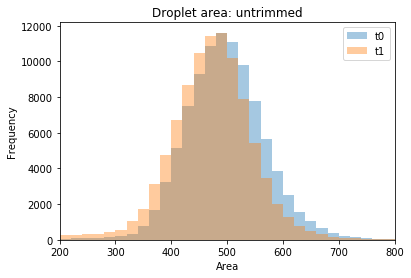

In [33]:
plt.hist(trimmed['t0_Area'],bins=50,range=(0,1000), label = 't0', alpha=0.4)
plt.hist(trimmed['t1_Area'],bins=50,range=(0,1000), label = 't1', alpha=0.4)
# plt.hist(trimmed['t2_Area'],bins=50,range=(0,1000), label = 't2', alpha=0.4)
# plt.hist(trimmed['t3_Area'],bins=50,range=(0,1000), label = 't3', alpha=0.4)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Droplet area: untrimmed')
plt.xlim(200,800)
plt.legend()
plt.show()

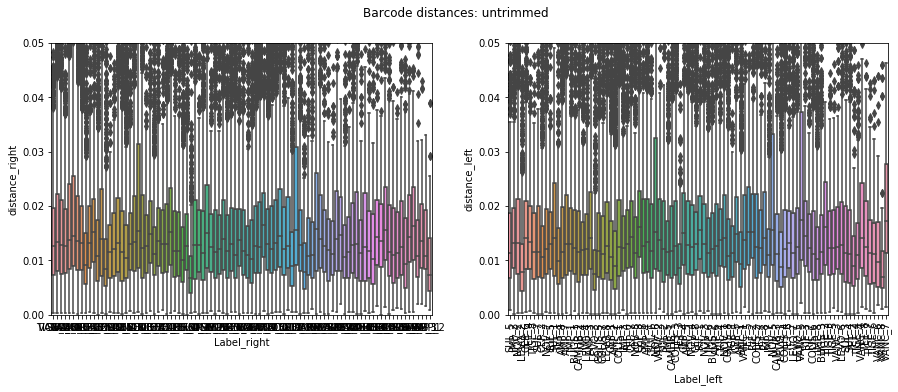

In [21]:
# To test barcode distances:
Ldist = trimmed[['Label_left','distance_left']]
# Lcolumn_order = guides
Rdist = trimmed[['Label_right','distance_right']]
# Rcolumn_order = targets

f, axes = plt.subplots(1, 2, figsize=(15,5))
# sns.boxplot(x='Label_left',y='distance_left',data=Ldist,order=Lcolumn_order, ax=axes[1])
# sns.boxplot(x='Label_right',y='distance_right',data=Rdist,order=Rcolumn_order, ax=axes[0])
sns.boxplot(x='Label_left',y='distance_left',data=Ldist, ax=axes[1])
sns.boxplot(x='Label_right',y='distance_right',data=Rdist, ax=axes[0])
plt.xticks(rotation=90)
ylim = [0.0,0.05]
plt.setp(axes, ylim=ylim)
f.suptitle('Barcode distances: untrimmed')
plt.show()
plt.close()

In [22]:
Ldistance_trimmed = trimmed[trimmed['distance_left']<0.035]
distance_trimmed = Ldistance_trimmed[Ldistance_trimmed['distance_right']<0.035]
print("barcode untrimmed",trimmed.shape)
print("barcode trimmed",distance_trimmed.shape)

barcode untrimmed (96783, 150)
barcode trimmed (83654, 150)


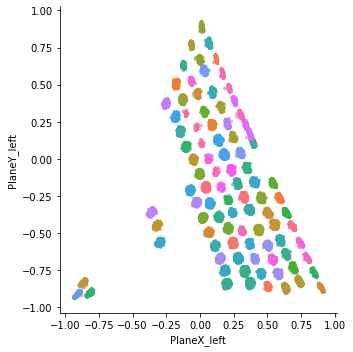

In [23]:
g = sns.FacetGrid(distance_trimmed, hue="Label_left", size=5)
g.map(plt.scatter, "PlaneX_left", "PlaneY_left", s=5, alpha=.5)
# g.add_legend();

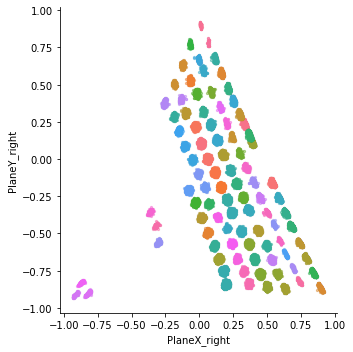

In [24]:
f = sns.FacetGrid(distance_trimmed, hue="Label_right", size=5)
f.map(plt.scatter, "PlaneX_right", "PlaneY_right", s=5, alpha=.5)
# f.add_legend();

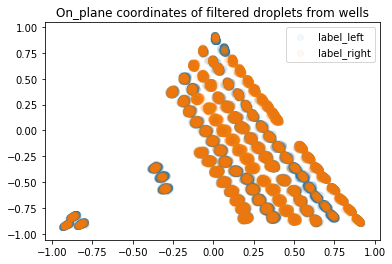

In [25]:
# Plots droplets onto the triangle, filtered
plt.scatter(distance_trimmed['PlaneX_left'],distance_trimmed['PlaneY_left'],alpha=0.05, label = 'label_left')
plt.scatter(distance_trimmed['PlaneX_right'],distance_trimmed['PlaneY_right'],alpha=0.05, label = 'label_right')
plt.gca().set_title('On_plane coordinates of filtered droplets from wells')
plt.legend()

In [26]:
d_area_trimmed = distance_trimmed[distance_trimmed['t0_Area']<650]
d_area_trimmed = d_area_trimmed[d_area_trimmed['t0_Area']>350]
print("aread trimmed",d_area_trimmed.shape)

aread trimmed (81142, 150)


In [27]:
d_area_trimmed.to_csv(newfolder+exp_date+'distance_and_area_filtered.csv')

## Well Locations

In [34]:
d_area_trimmed = pd.read_csv(newfolder+exp_date+'distance_and_area_filtered.csv',index_col=0)

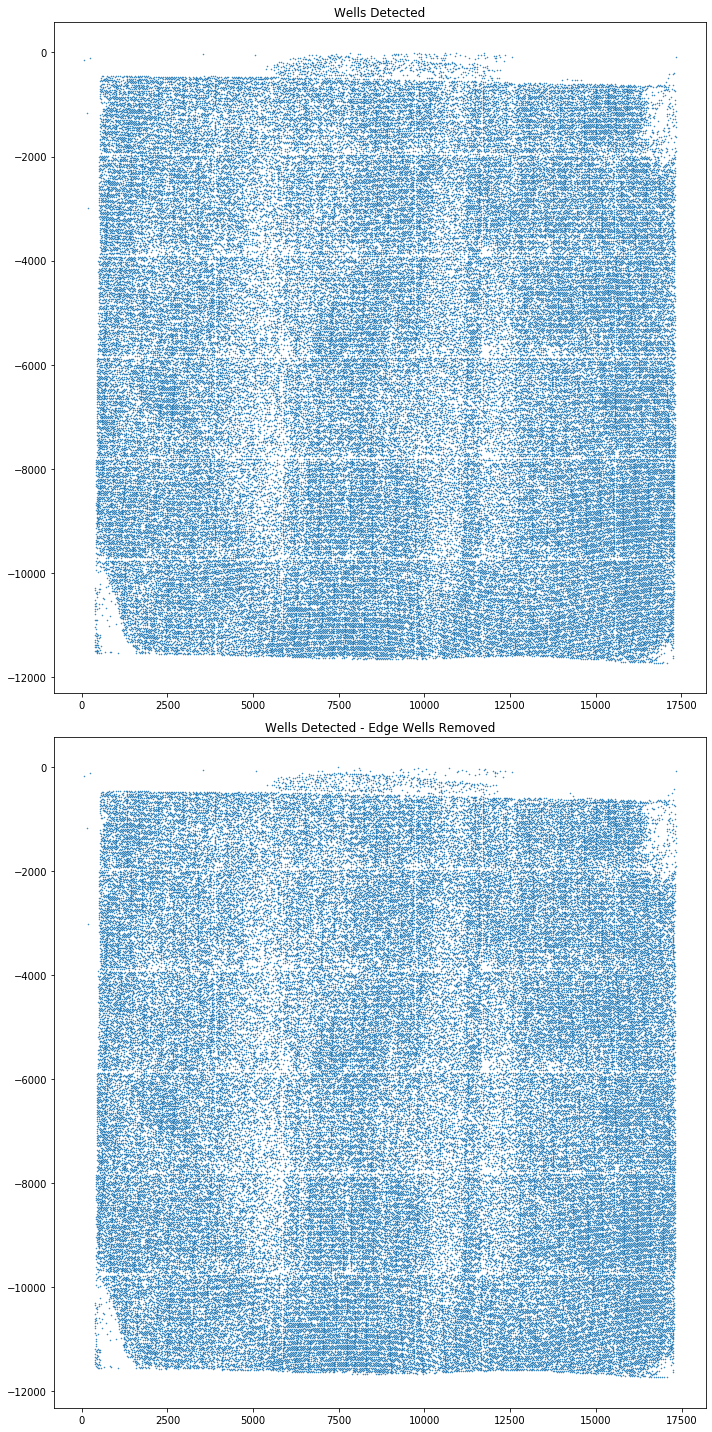

In [35]:
# Plot locations of all identified droplets on 2D plane to represent the chip
# Can identify portion of chip where droplet identification failed
# Regions may due to cross merging
fig, axes = plt.subplots(2,1,figsize=(10,20))

axes[0].plot(pre_post['Pre_GlobalX'],-pre_post['Pre_GlobalY'],'.',ms=1)
axes[0].set_title('Wells Detected')
# axes[0].set_axis_off()

axes[1].plot(pre_post['Post_GlobalX'],-pre_post['Post_GlobalY'],'.',ms=1)
axes[1].set_title('Wells Detected - Edge Wells Removed')
# axes[1].set_axis_off()

plt.tight_layout()

## Label Counts

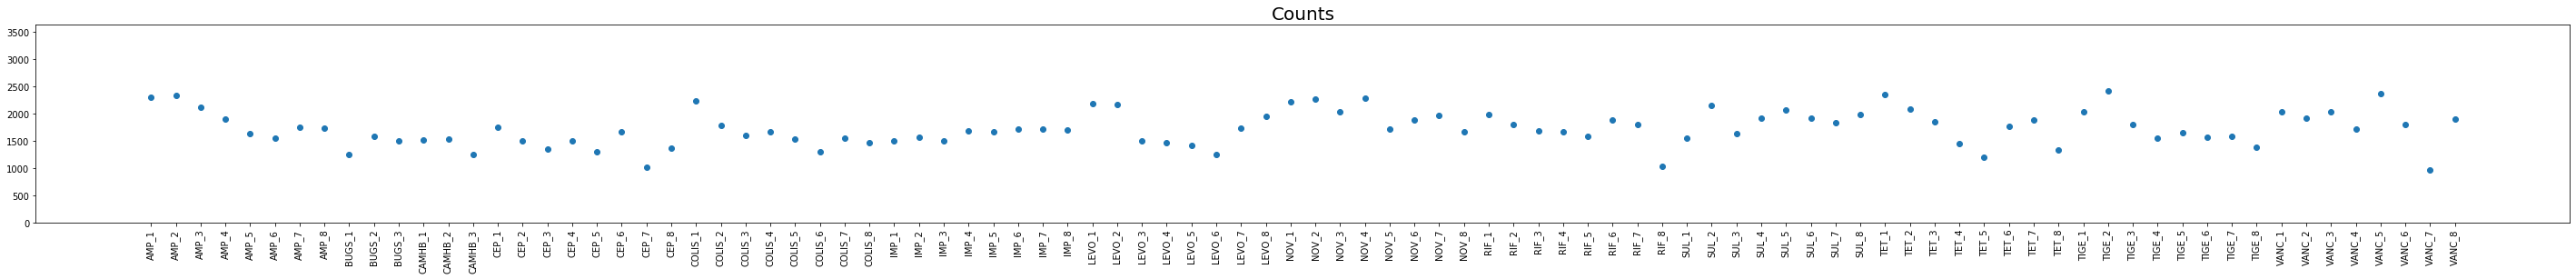

In [29]:
# labels = targets+guides
# counts = d_area_trimmed.sum()[labels]
left_count = d_area_trimmed['Label_left'].value_counts()
right_count = d_area_trimmed['Label_right'].value_counts()
counts = left_count + right_count
# print(counts)

fig, axes = plt.subplots(1,1,figsize=(50,4))
axes.plot(counts.values,'o')
axes.set_xticks(range(len(counts.index.values)))
axes.set_xticklabels(counts.index.values,size=10,rotation=90)
plt.ylim(0, 1.5*max(counts))
axes.set_title('Counts',size=20)
plt.savefig(newfolder+exp_date+'Label_counts.png',bbox_inches='tight',dpi=300)

## MIC Analysis

In [12]:
d_area_trimmed = pd.read_csv(newfolder+exp_date+'distance_and_area_filtered.csv',index_col=0)

In [81]:
bug_drops = d_area_trimmed[(d_area_trimmed.Label_left.str.contains('BUGS')) & (d_area_trimmed.Label_right.str.contains('BUGS'))]
media_drops = d_area_trimmed[(d_area_trimmed.Label_left.str.contains('CAMHB')) & (d_area_trimmed.Label_right.str.contains('CAMHB'))]
print('# of bug controls: '+ str(len(bug_drops)))
print('# of media controls: '+ str(len(media_drops)))

# of bug controls: 113
# of media controls: 132


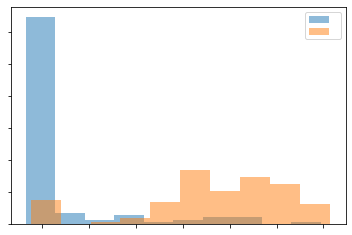

In [82]:
plt.hist(media_drops.t1_norm2,density=True,alpha=0.5,label='media')
plt.hist(bug_drops.t1_norm2,density=True,alpha=0.5,label='bugs')
plt.legend()

In [83]:
bugmedia_drops = d_area_trimmed[(d_area_trimmed.Label_left.str.contains('BUGS')) & (d_area_trimmed.Label_right.str.contains('CAMHB'))]
bugmed_med = bugmedia_drops.t1_norm2.median()
d_area_trimmed['t1_normbugs'] = d_area_trimmed.t1_norm2 / bugmed_med

In [84]:
d_area_trimmed['abx'] = d_area_trimmed.Label_left.apply(lambda x: x.split('_')[0])
abxs = d_area_trimmed.abx.unique()

In [85]:
def bootstrap_median(df):
    # resample from all dataframe rows
    return np.median(np.random.choice(df, len(df)))
def bliss_boot(df,parallel=False):
    med_agg = bootstrap_median if parallel else 'median'
    grouped = df[['Label_left','Label_right','t1_normbugs']].groupby(['Label_left','Label_right'])
    return grouped.aggregate(med_agg)

In [86]:
indlen = d_area_trimmed[['Label_left','Label_right','t1_normbugs']].groupby(['Label_left','Label_right']).count().shape[0]
ar = np.ndarray((indlen,1000))
d_area_trimmed = d_area_trimmed.dropna(subset=['t1_normbugs'])
print(ar.shape)
for i in range(1000):
    boot_ = bliss_boot(d_area_trimmed,parallel=True).t1_normbugs.values
    ar[:,i] = boot_
MED = d_area_trimmed[['Label_left','Label_right','t1_normbugs','abx']].groupby(['Label_left','Label_right']).median()
MED['SE'] = ar.std(axis=1)
d_area_trimmed.to_csv(newfolder+exp_date+'distance_and_area_filtered_v2.csv')
MED.to_csv(newfolder+exp_date+'summary_data.csv')

(4465, 1000)


In [101]:
d_area_trimmed['comboID'] = d_area_trimmed[['Label_left','Label_right']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)
MED = MED.reset_index()
MED['comboID'] = MED[['Label_left','Label_right']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)
SE_dict = dict(zip(MED.comboID, MED.SE))
d_area_trimmed['SE'] = d_area_trimmed['comboID'].map(SE_dict)
d_area_trimmed.to_csv(newfolder+exp_date+'distance_and_area_filtered_v3.csv')

In [39]:
d_area_trimmed = pd.read_csv(newfolder+exp_date+'distance_and_area_filtered_v3.csv',index_col=0)
abxs = d_area_trimmed.abx.unique()

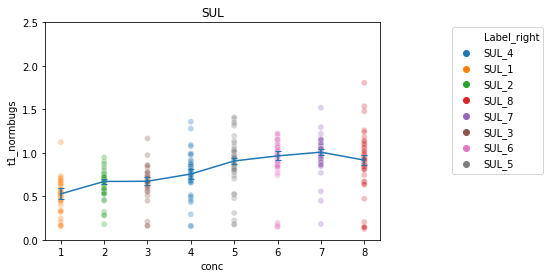

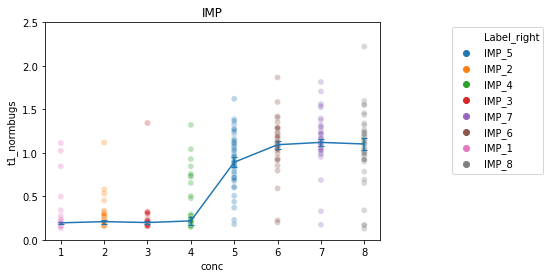

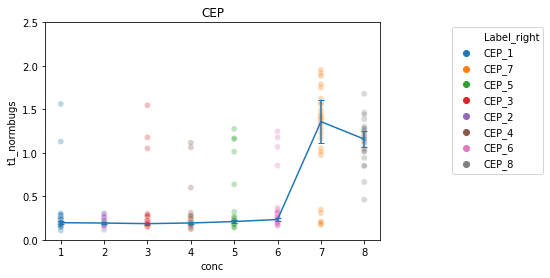

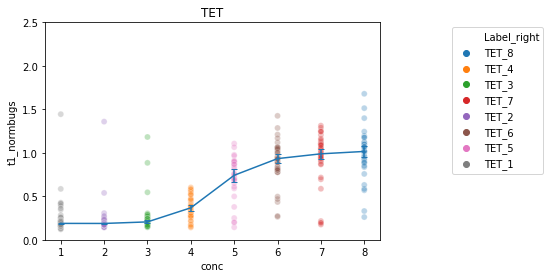

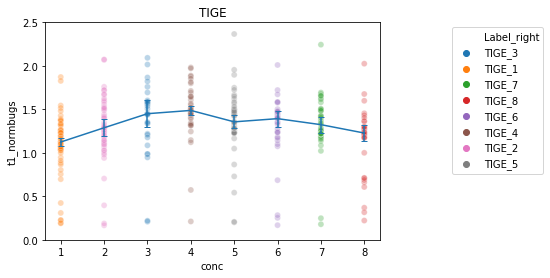

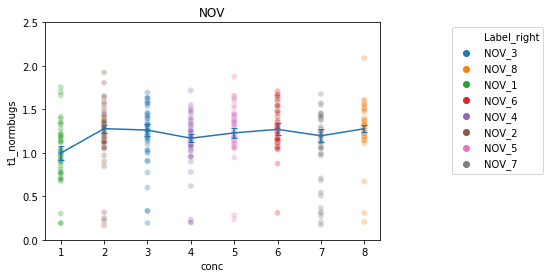

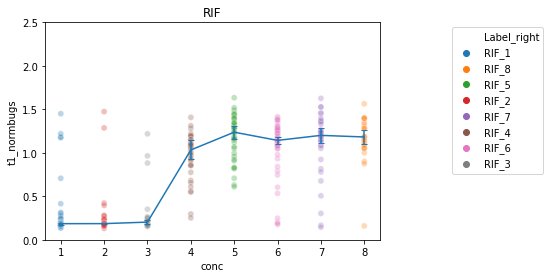

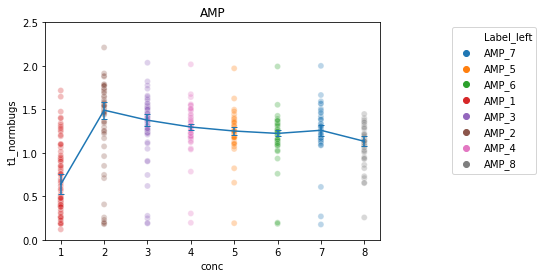

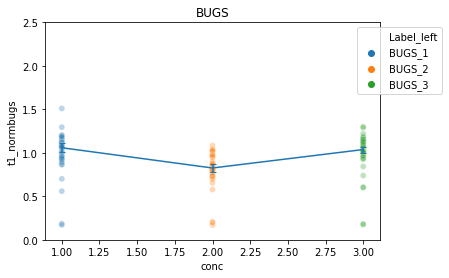

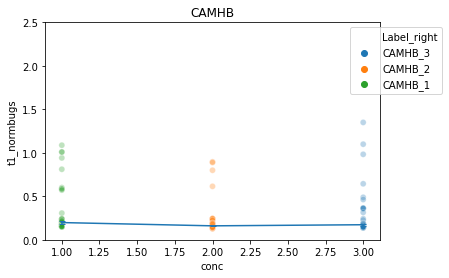

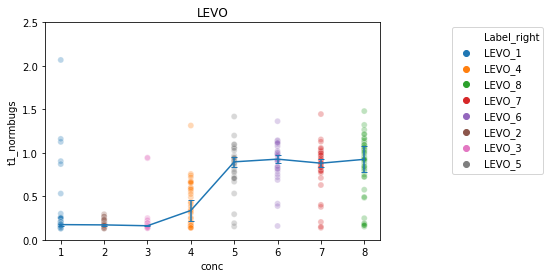

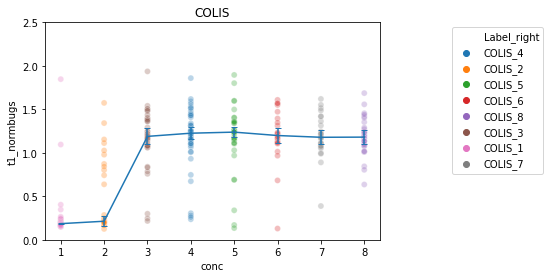

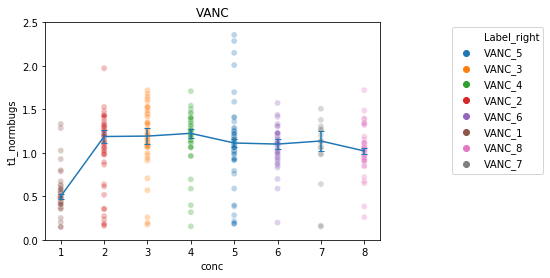

In [9]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages(newfolder+'prelim_MIC_curves_norm_1Xbug.pdf')
for i in abxs:
    abx_drops_r = d_area_trimmed[(d_area_trimmed.Label_right.str.contains(i)) & (d_area_trimmed.Label_left.str.contains('CAMHB'))]
    abx_drops_l = d_area_trimmed[(d_area_trimmed.Label_right.str.contains('CAMHB')) & (d_area_trimmed.Label_left.str.contains(i))]
    if abx_drops_r.shape[0]>0:
        abx_drops = abx_drops_r
        abx_drops['conc'] = abx_drops.Label_right.apply(lambda x: int(x[-1]))
        med = abx_drops.groupby('conc').median()
        plt.figure()
        sns.scatterplot(data=abx_drops, x="conc", y="t1_normbugs", hue="Label_right",alpha=0.3)
        plt.errorbar(med.index,med.t1_normbugs,yerr=med.SE,capsize=3)
        plt.title(i)
        plt.ylim([0,2.5])
        plt.legend(bbox_to_anchor=(1.2,1))
        plt.savefig(pp, format='pdf',bbox_inches='tight',dpi=300)
    elif abx_drops_l.shape[0]>0:
        abx_drops = abx_drops_l
        abx_drops['conc'] = abx_drops.Label_left.apply(lambda x: int(x[-1]))
        med = abx_drops.groupby('conc').median()
        plt.figure()
        sns.scatterplot(data=abx_drops, x="conc", y="t1_normbugs", hue="Label_left",alpha=0.3)
        plt.errorbar(med.index,med.t1_normbugs,yerr=med.SE,capsize=3)
        plt.title(i)
        plt.ylim([0,2.5])
        plt.legend(bbox_to_anchor=(1.2,1))
        plt.savefig(pp, format='pdf',bbox_inches='tight',dpi=300)
pp.close()